# Final Analysis

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#Read tweets from csv file
df=pd.read_csv("Trump tweets 3 day groups jan-dec 2017.csv")

#Changing the date format
for index, row in df.iterrows():
    #row['startdate']=row['startdate'].date()
    d= datetime.strptime(row['created_at'], '%m/%d/%Y')
    df.loc[index, 'created_at'] = d.strftime('%Y-%m-%d')

#first tweet variable
#true for the first time then set to false
firstTweet = True

#list to store compound sentiment for each tweet
#once unique identifier is different averaged and emptied
compound_list =[]

#Array to store average compound sentiments
sentiments =[]
count =0

#Iterate over all the tweet data stored in dataframe
for index, row in df.iterrows():
    
    #Run Vader Analysis on each tweet
    sentence =row["text"]
    
    #Getting average compund sentiment for three days
    #Three days tweets have same unique identifier
    new_id =row["Unique Identifier"]
    
    #If not first tweet 
        ##Check if the old and new unique identifiers are different
            ####If different save the average compound sentiment
            ####Empty the compound list
            ####Add the average compound sentiment to an array
            ####Set the counter to 0
            ####Set the old_date  value
    #Else 
    ##Set firstTweet to false
    ##Set the ol_date for first set of sentiments 
    if(firstTweet == False):               
        if(old_id != new_id):
            compound= np.mean(compound_list)
            compound_list =[]
            sentiments.append({"Compound":compound,
                "Date" : old_date,
                "Count" : count})
            count =0
            old_date = row["created_at"]
    else:
        firstTweet = False
        old_date = row["created_at"]
    
    #Add all the tweet to compound list
    #Increment the counter
    #Change the old_id and old_values     
    compound_list.append(analyzer.polarity_scores(sentence)["compound"])
    count +=1
    old_id = new_id
        
#Add the final set of average compund sentiment
sentiments.append({"Compound":compound,
                "Date" : old_date,
                "Count" : count})

#Put all data into dataframe sentiments_df
sentiments_df = pd.DataFrame.from_dict(sentiments)
sentiments_df =sentiments_df[['Date','Compound','Count']]

sentiments_df.head(10)

,Date,Compound,Count
0,2017-01-20,0.185511,18
1,2017-01-23,0.183223,13
2,2017-01-26,0.106478,23
3,2017-01-29,-0.232106,17
4,2017-02-01,0.069474,19
5,2017-02-04,-0.165157,21
6,2017-02-07,0.004900,24
7,2017-02-10,0.082024,21
8,2017-02-13,0.107675,20
9,2017-02-16,-0.028606,18


In [2]:
#Read tweets approval ratings from csv file
df1=pd.read_csv("approval data clean values only.csv")

#Changing the date format
#Keeping only one date and renaming it to 'Date'
#Filtering the data to keep values only from 2017-01-20 to 2017-12-31
for index, row in df1.iterrows():
    d= datetime.strptime(row['Start Date'], '%m/%d/%Y')
    df1.loc[index, 'Start Date'] = d.strftime('%Y-%m-%d')
df1.rename( columns={"Start Date": "Date"}, inplace=True)
df1=df1.loc[(df1['Date'] > '2017-01-19') & (df1['Date'] < '2018-01-01')]
approval_df=df1[['Date','Average of adjusted_approve','Average of adjusted_disapprove']]

#Performing merge based on the 'Date' column
#Removing any rows having NaN values or no values
correlate_df =sentiments_df.merge(approval_df,on='Date',how="outer")
correlate_df =correlate_df[['Date','Compound','Average of adjusted_approve','Average of adjusted_disapprove']]
correlate_df.rename( columns={"Average of adjusted_approve": "Approve","Average of adjusted_disapprove": "Disapprove"}, inplace=True)
correlate_df = correlate_df.dropna(axis=0, how='any')

#Convert compound sentiment range max being 1 and min being -1 into percentage. i.e -1 = 0% and 1 =100%
#((input - min) * 100) / (max - min)
max=1
min =-1
for index, row in correlate_df.iterrows():
    d= ((row['Compound'] - min) * 100) / (max - min)
    correlate_df.loc[index, 'Compound'] = d
    
df1.head(10)

,Date,End Date,Average of adjusted_approve,Average of adjusted_disapprove
0,2017-01-20,1/22/2017,45.90613,43.14093
1,2017-01-23,1/25/2017,43.71903,40.23624
2,2017-01-26,1/28/2017,42.90613,49.14093
3,2017-01-29,1/31/2017,43.90613,50.14093
4,2017-02-01,2/3/2017,44.90613,48.14093
5,2017-02-04,2/6/2017,42.90613,52.14093
6,2017-02-07,2/9/2017,42.90613,50.14093
7,2017-02-10,2/12/2017,40.90613,52.14093
8,2017-02-13,2/15/2017,40.90613,52.14093
9,2017-02-16,2/18/2017,41.90613,53.14093


# DF containing Date, Compount(Sentiment), Approval and Disapproval rates:

In [3]:
correlate_df.head()

,Date,Compound,Approve,Disapprove
0,2017-01-20,59.275556,45.90613,43.14093
1,2017-01-23,59.161154,43.71903,40.23624
2,2017-01-26,55.323913,42.90613,49.14093
3,2017-01-29,38.394706,43.90613,50.14093
4,2017-02-01,53.473684,44.90613,48.14093


# Compound vs Disapprove

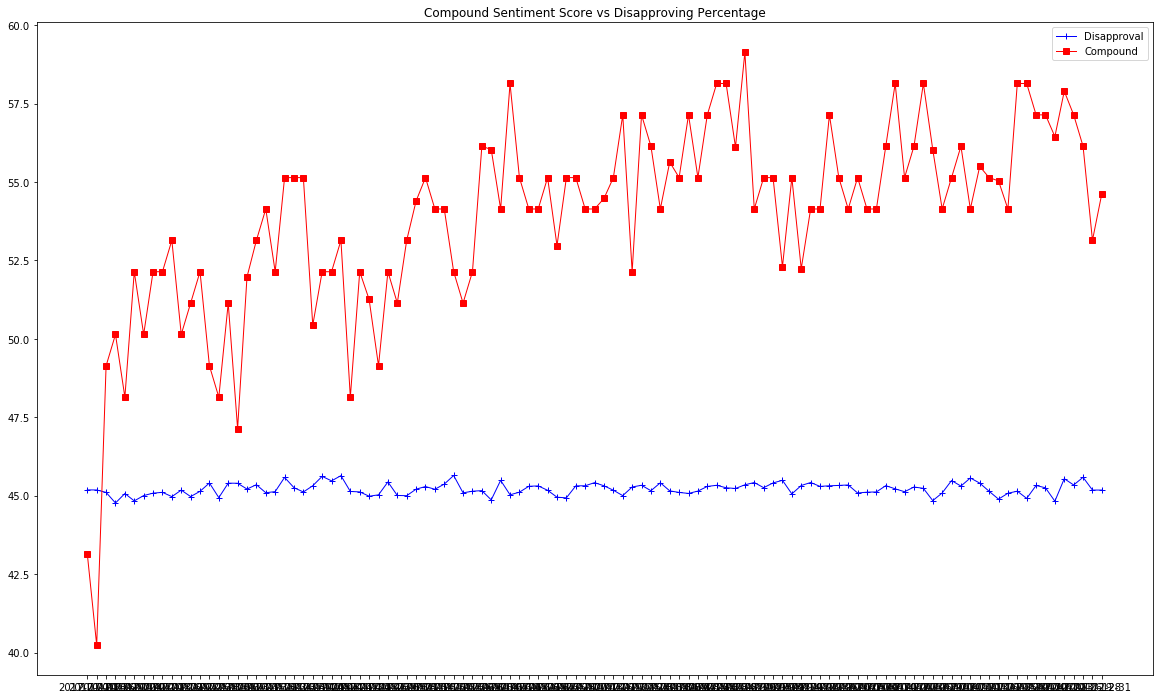

In [26]:
plt.figure(figsize=(20,12))
x_axis = correlate_df['Date']
plt.legend((Compound[0], Approve[0]), ('Disapproval', 'Compound'))
plt.title('Compound Sentiment Score vs Disapproving Percentage')
# Create a handle for each plot
Compound = plt.plot(x_axis, correlate_df['Compound']+45, marker="+",color="blue", linewidth=1, label="Sentiment")
Approve = plt.plot(x_axis, correlate_df['Disapprove'], marker="s", color="Red", linewidth=1, label="Disapprove")
plt.show()

# Compound vs Approve vs Disapprove

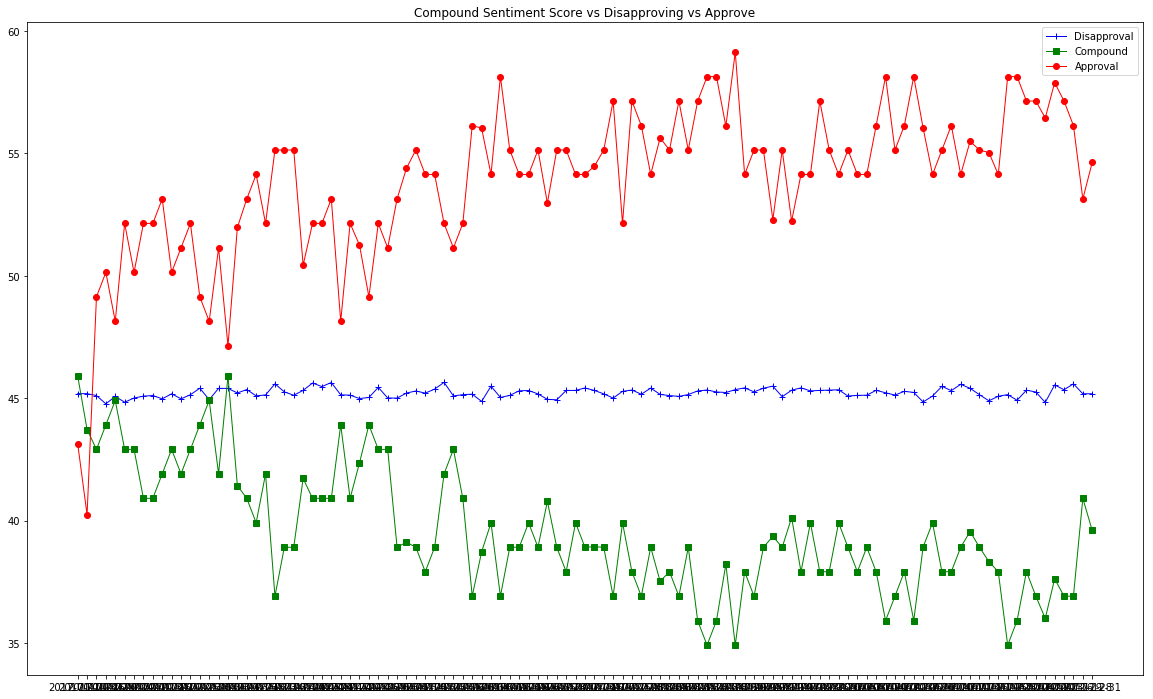

In [28]:
#Plotting line graph for bottom 10 of narrowed values
plt.figure(figsize=(20,12))
x_axis = correlate_df['Date']
plt.legend((Compound[0], Approve[0],Disapprove[0]), ('Disapproval', 'Compound', 'Approval'))
plt.title('Compound Sentiment Score vs Disapproving vs Approve')
# Create a handle for each plot
Compound = plt.plot(x_axis, correlate_df['Compound']+45, marker="+",color="blue", linewidth=1, label="Sentiment")
Approve = plt.plot(x_axis, correlate_df['Approve'], marker="s", color="Green", linewidth=1, label="Approve")
Disapprove = plt.plot(x_axis, correlate_df['Disapprove'], marker="o", color="Red", linewidth=1, label="Disapprove")
plt.show()

# S&P Closing Prices w/ Approval rates DF

In [35]:
#Importing S&P Data
SP_data = "S&P 500 Raw data_1-20-2017 ~ 3-21-2018.csv"
SP_df = pd.read_csv(SP_data, encoding = "ISO-8859-1")

correlate_df =sentiments_df.merge(approval_df,on='Date',how="outer")
correlate_df =correlate_df[['Date','Compound','Average of adjusted_approve','Average of adjusted_disapprove']]
correlate_df.rename( columns={"Average of adjusted_approve": "Approve","Average of adjusted_disapprove": "Disapprove"}, inplace=True)
correlate_df = correlate_df.dropna(axis=0, how='any')

merged_data = pd.merge(correlate_df, SP_df, how='inner', on='Date')
merged_data = merged_data[['Date','Compound','Approve','Disapprove','Close']]
merged_data.head()

,Date,Compound,Approve,Disapprove,Close
0,2017-01-20,0.185511,45.90613,43.14093,2271.310059
1,2017-01-23,0.183223,43.71903,40.23624,2265.199951
2,2017-01-26,0.106478,42.90613,49.14093,2296.679932
3,2017-02-01,0.069474,44.90613,48.14093,2279.550049
4,2017-02-07,0.004900,42.90613,50.14093,2293.080078


# Approval vs Disapproval vs Closing Prices

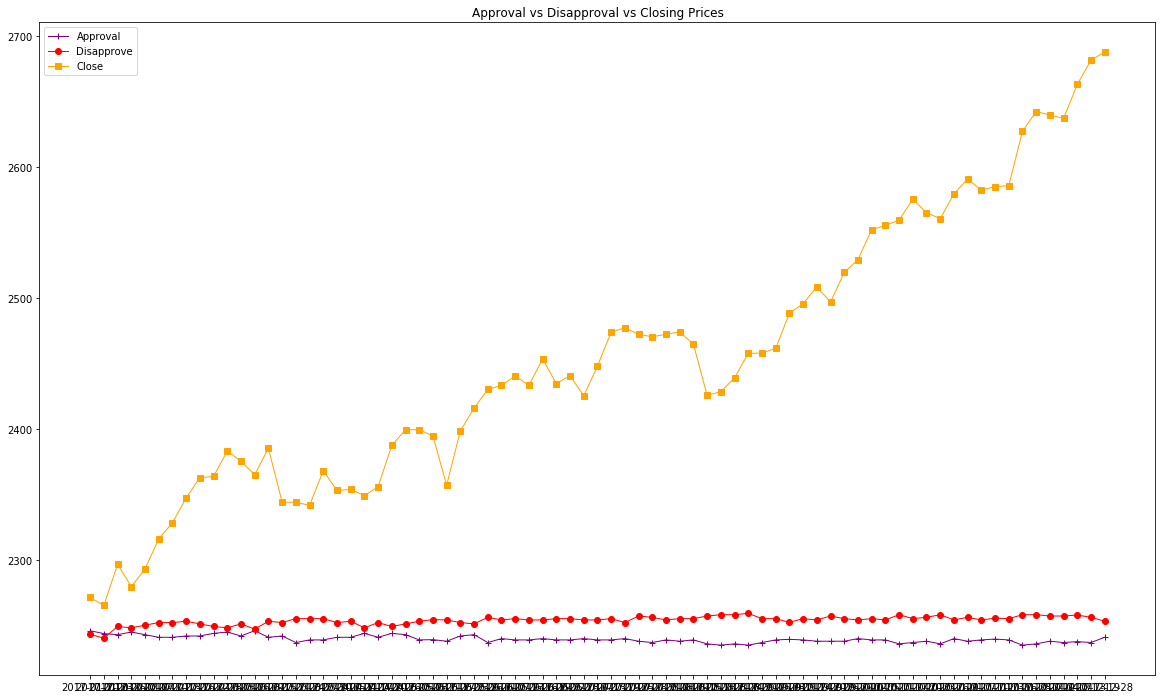

In [38]:
plt.figure(figsize=(20,12))
x_axis = merged_data['Date']
plt.title('Approval vs Disapproval vs Closing Prices')
# Create a handle for each plot
Approve = plt.plot(x_axis, merged_data['Approve']+2200, marker="+",color="Purple", linewidth=1, label="Closing Price")
Close = plt.plot(x_axis, merged_data['Close'], marker="s", color="Orange", linewidth=1, label="Compound")
Disapprove = plt.plot(x_axis, merged_data['Disapprove']+2200, marker="o", color="Red", linewidth=1, label="Disapprove")
plt.legend((Approve[0],Disapprove[0],Close[0]), ('Approval','Disapprove', 'Close'))
plt.show()

# Compound Score vs Closing Prices

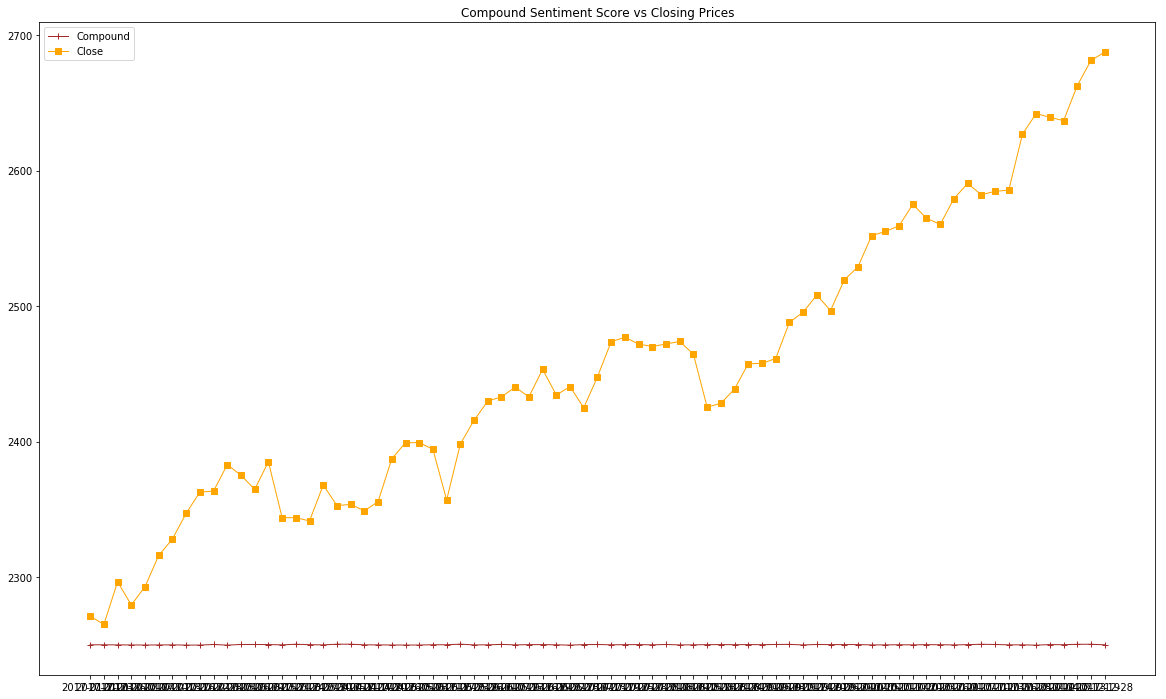

In [39]:
plt.figure(figsize=(20,12))
x_axis = merged_data['Date']
plt.title('Compound Sentiment Score vs Closing Prices')
plt.legend((Compound[0],Close[0]), ('Compound', 'Close'))
# Create a handle for each plot
Compound = plt.plot(x_axis, merged_data['Compound']+2250, marker="+",color="Brown", linewidth=1, label="Closing Price")
Close = plt.plot(x_axis, merged_data['Close'], marker="s", color="Orange", linewidth=1, label="Compound")
plt.show()

In [42]:
#Read tweets from csv file
df = pd.read_csv("SPvsCompound.csv")
close_values = df['Close'].unique()
compound_values = df['Average of Compound'].unique()

delta_close = []
delta_compound = []

for i in range(43):
    delta_close.append(float(close_values[i + 1]) - float(close_values[i]))
    delta_compound.append(float(compound_values[i + 1]) - float(compound_values[i]))
    
days = np.arange(43)

deltas_df = pd.DataFrame({'Day Number': days, 'Delta Compound': delta_compound, 'Delta Close': delta_close})
deltas_df.head()

,Day Number,Delta Close,Delta Compound
0,0,4.600097,0.096921
1,1,-4.310058,0.061467
2,2,2.239990,-0.159449
3,3,4.469971,0.266504
4,4,1.720214,-0.014711


# Change in Closing Prices vs Change in Compound Sentiment Score

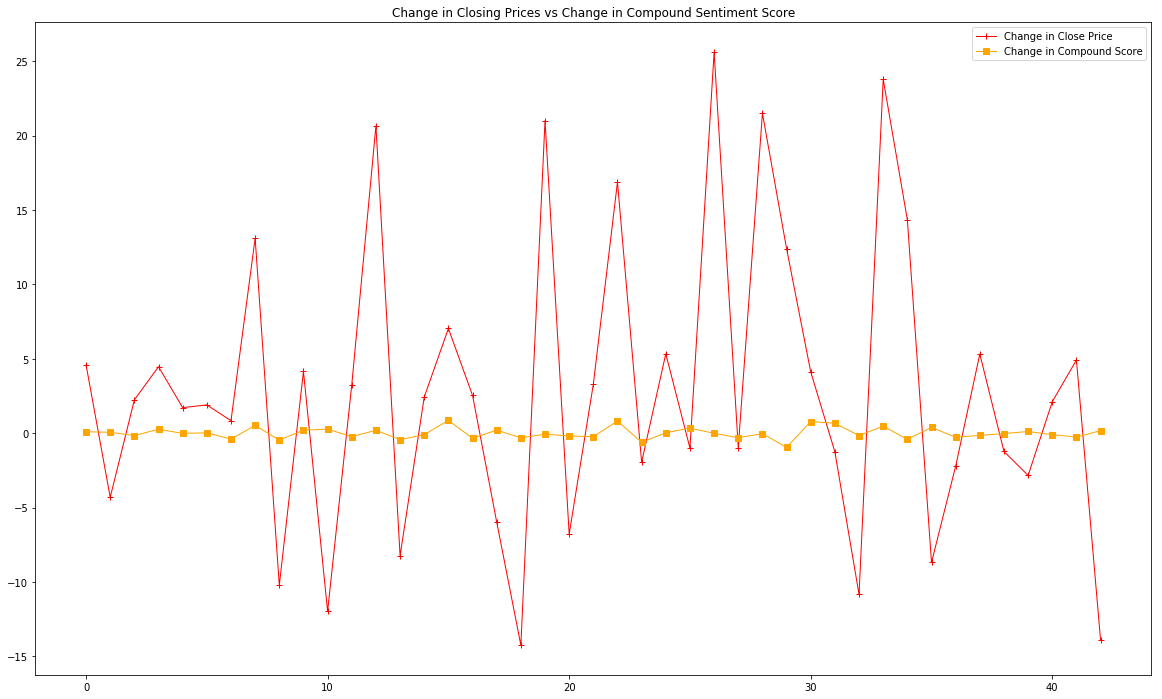

In [45]:
plt.figure(figsize=(20,12))
x_axis = deltas_df['Day Number']

plt.title('Change in Closing Prices vs Change in Compound Sentiment Score')
# Create a handle for each plot
DClose = plt.plot(x_axis, deltas_df['Delta Close'], marker="+",color="Red", linewidth=1, label="Closing Price")
Dcompound = plt.plot(x_axis, deltas_df['Delta Compound'], marker="s", color="Orange", linewidth=1, label="Compound")
plt.legend((DClose[0], Dcompound[0]), ('Change in Close Price', 'Change in Compound Score'))
plt.show()

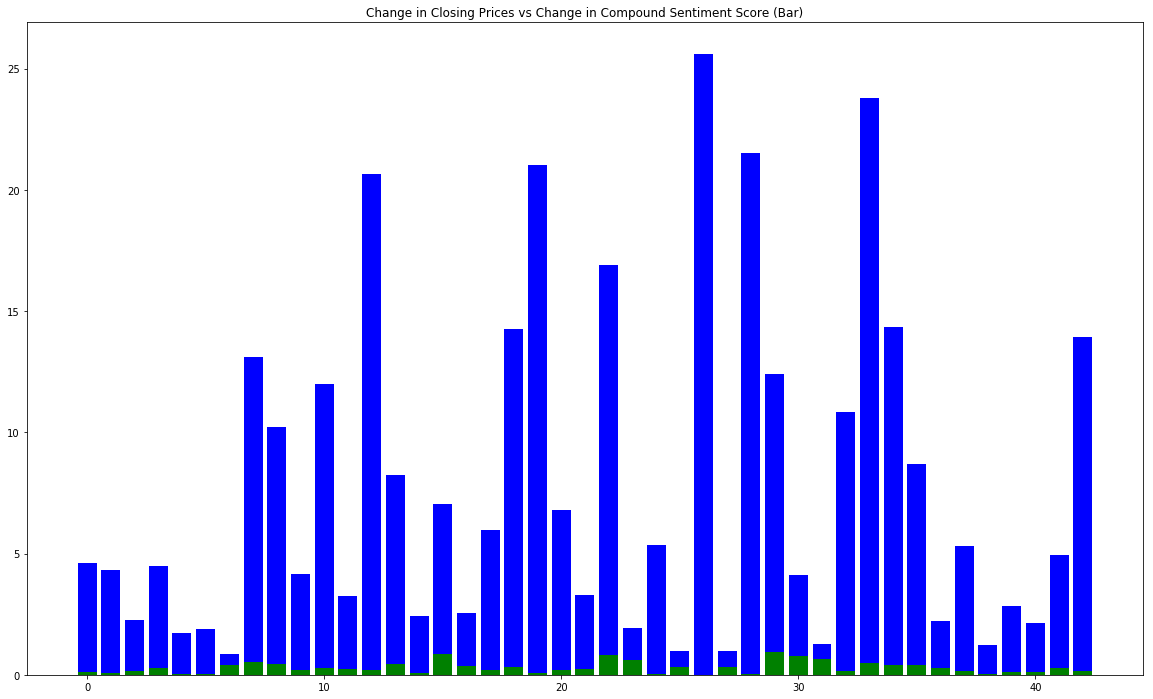

In [47]:
#Create a barplot for sentiment analysis and approval
plt.figure(figsize=(20,12))
plt.title('Change in Closing Prices vs Change in Compound Sentiment Score (Bar)')
plt.bar(x_axis, np.sqrt(np.square(deltas_df['Delta Close'])), color="blue")
plt.bar(x_axis, np.sqrt(np.square(deltas_df['Delta Compound'])), color="green")
plt.show()

In [49]:
#Read tweets from csv file
df=pd.read_csv("Trump tweets 3 day groups jan-dec 2017.csv")

#Changing the date format
for index, row in df.iterrows():
    #row['startdate']=row['startdate'].date()
    d= datetime.strptime(row['created_at'], '%m/%d/%Y')
    df.loc[index, 'created_at'] = d.strftime('%Y-%m-%d')
#first tweet variable
#true for the first time then set to false
firstTweet = True

#list to store compound sentiment for each tweet
#once unique identifier is different averaged and emptied
compound_list =[]

#Array to store average compound sentiments
sentiments =[]
count =0

#Iterate over all the tweet data stored in dataframe
for index, row in df.iterrows():
    
    #Run Vader Analysis on each tweet
    sentence =row["text"]
    
    #Getting average compund sentiment for three days
    #Three days tweets have same unique identifier
    new_id =row["Unique Identifier"]
    
    #If not first tweet 
        ##Check if the old and new unique identifiers are different
            ####If different save the average compound sentiment
            ####Empty the compound list
            ####Add the average compound sentiment to an array
            ####Set the counter to 0
            ####Set the old_date  value
    #Else 
    ##Set firstTweet to false
    ##Set the ol_date for first set of sentiments 
    if(firstTweet == False):               
        if(old_id != new_id):
            compound= np.mean(compound_list)
            compound_list =[]
            sentiments.append({"Compound":compound,
                "Date" : old_date,
                "Count" : count})
            count =0
            old_date = row["created_at"]
    else:
        firstTweet = False
        old_date = row["created_at"]
    
    #Add all the tweet to compound list
    #Increment the counter
    #Change the old_id and old_values     
    compound_list.append(analyzer.polarity_scores(sentence)["compound"])
    count +=1
    old_id = new_id
        
#Add the final set of average compund sentiment
sentiments.append({"Compound":compound,
                "Date" : old_date,
                "Count" : count})

#Put all data into dataframe sentiments_df
sentiments_df = pd.DataFrame.from_dict(sentiments)
sentiments_df =sentiments_df[['Date','Compound','Count']]
sentiments_df.head()

#Read tweets approval ratings from csv file
df1=pd.read_csv("approval data clean values only.csv")
df1.head()

#Changing the date format
#Keeping only one date and renaming it to 'Date'
#Filtering the data to keep values only from 2017-01-20 to 2017-12-31
for index, row in df1.iterrows():
    d= datetime.strptime(row['Start Date'], '%m/%d/%Y')
    df1.loc[index, 'Start Date'] = d.strftime('%Y-%m-%d')
df1.rename( columns={"Start Date": "Date"}, inplace=True)
df1=df1.loc[(df1['Date'] > '2017-01-19') & (df1['Date'] < '2018-01-01')]
approval_df=df1[['Date','Average of adjusted_approve','Average of adjusted_disapprove']]

#Performing merge based on the 'Date' column
#Removing any rows having NaN values or no values
correlate_df =sentiments_df.merge(approval_df,on='Date',how="outer")
correlate_df =correlate_df[['Date','Compound','Average of adjusted_approve','Average of adjusted_disapprove']]
correlate_df.rename( columns={"Average of adjusted_approve": "Approve","Average of adjusted_disapprove": "Disapprove"}, inplace=True)
correlate_df = correlate_df.dropna(axis=0, how='any')

approval_values = correlate_df['Approve'].unique()
compound_values = correlate_df['Compound'].unique()

delta_approval = []
delta_compound = []

for i in range(29):
    delta_approval.append(float(approval_values[i + 1]) - float(approval_values[i]))
    delta_compound.append(float(compound_values[i + 1]) - float(compound_values[i]))
    
delta_approval = delta_approval[:29]
delta_compound = delta_compound[:29]

days = np.arange(29)

deltas_df = pd.DataFrame({'Day Number': days, 'Delta Approval': delta_approval, 'Delta Compound': delta_compound})

deltas_df.head()

,Day Number,Delta Approval,Delta Compound
0,0,-2.1871,-0.002288
1,1,-0.8129,-0.076745
2,2,1.0000,-0.338584
3,3,1.0000,0.301580
4,4,-4.0000,-0.234631


# Change in Approval vs Change in Compound Score 

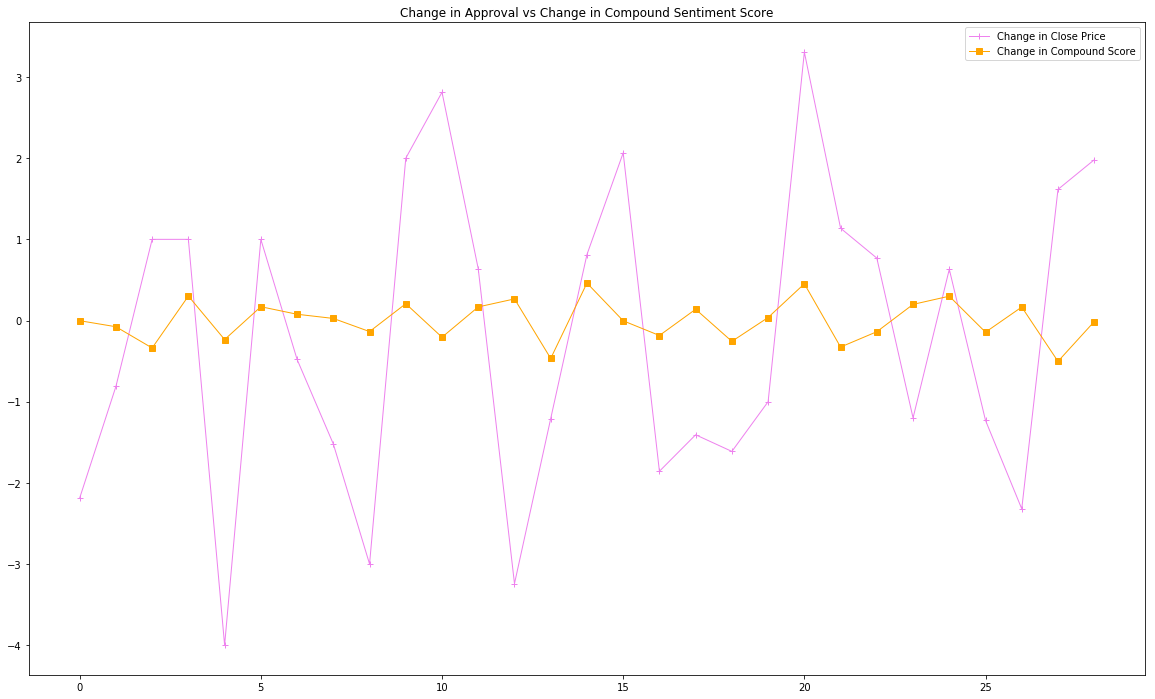

In [52]:
plt.figure(figsize=(20,12))
x_axis = deltas_df['Day Number']
plt.title('Change in Approval vs Change in Compound Sentiment Score')
# Create a handle for each plot
DeltaApproval = plt.plot(x_axis, deltas_df['Delta Approval'], marker="+",color="Violet", linewidth=1, label="Closing Price")
DeltaCompound = plt.plot(x_axis, deltas_df['Delta Compound'], marker="s", color="Orange", linewidth=1, label="Compound")
plt.legend((DeltaApproval[0], DeltaCompound[0]), ('Change in Close Price', 'Change in Compound Score'))
plt.show()

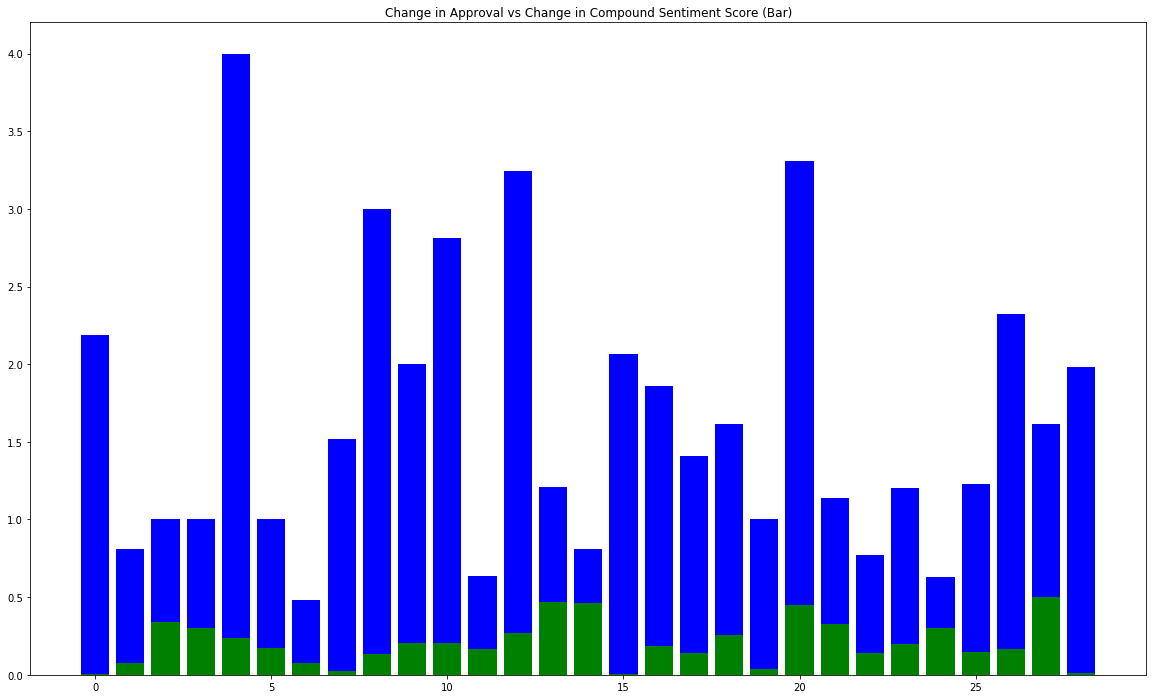

In [53]:
#Create a barplot for sentiment analysis and approval
plt.figure(figsize=(20,12))
plt.title('Change in Approval vs Change in Compound Sentiment Score (Bar)')
plt.bar(x_axis, np.sqrt(np.square(deltas_df['Delta Approval'])), color="blue")
plt.bar(x_axis, np.sqrt(np.square(deltas_df['Delta Compound'])), color="green")
plt.show()